In [1]:
import torch
from transformers import Owlv2Processor, Owlv2ForObjectDetection


C:\Users\willi\AppData\Roaming\Python\Python311\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
C:\Users\willi\AppData\Roaming\Python\Python311\site-packages\transformers\utils\generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


C:\Users\willi\AppData\Roaming\Python\Python311\site-packages\transformers\utils\generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [2]:
import requests
from PIL import Image


processor = Owlv2Processor.from_pretrained("google/owlv2-base-patch16-ensemble")
model = Owlv2ForObjectDetection.from_pretrained("google/owlv2-base-patch16-ensemble")


preprocessor_config.json:   0%|          | 0.00/425 [00:00<?, ?B/s]

c:\Python311\Lib\site-packages\huggingface_hub\file_download.py:147: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\willi\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


tokenizer_config.json:   0%|          | 0.00/1.10k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/67.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/121 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/620M [00:00<?, ?B/s]

In [3]:

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)
texts = [["a photo of a cat", "a photo of a dog"]]
inputs = processor(text=texts, images=image, return_tensors="pt")
outputs = model(**inputs)

# Target image sizes (height, width) to rescale box predictions [batch_size, 2]
# target_sizes = torch.Tensor([image.size[::-1]])
target_sizes = torch.Tensor([image.size[::-1]])
# Convert outputs (bounding boxes and class logits) to Pascal VOC Format (xmin, ymin, xmax, ymax)
results = processor.post_process_object_detection(outputs=outputs, target_sizes=target_sizes, threshold=0.1)
i = 0  # Retrieve predictions for the first image for the corresponding text queries
text = texts[i]
boxes, scores, labels = results[i]["boxes"], results[i]["scores"], results[i]["labels"]
for box, score, label in zip(boxes, scores, labels):
    box = [round(i, 2) for i in box.tolist()]
    print(f"Detected {text[label]} with confidence {round(score.item(), 3)} at location {box}")

Detected a photo of a cat with confidence 0.614 at location [341.67, 17.54, 642.32, 278.51]
Detected a photo of a cat with confidence 0.665 at location [6.75, 38.97, 326.62, 354.85]


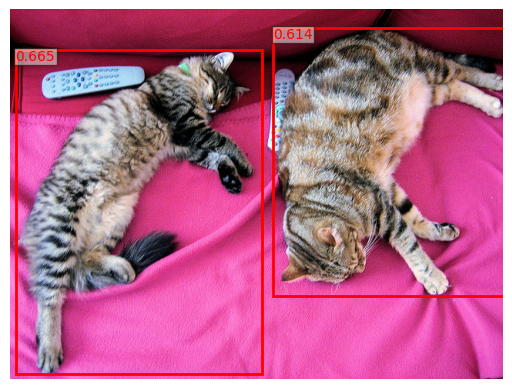

In [4]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import requests
from PIL import Image
from io import BytesIO

# Image URL
url = "http://images.cocodataset.org/val2017/000000039769.jpg"

# Bounding box coordinates and confidence levels
boxes = [
    [341.67, 23.39, 642.32, 371.35, 0.614],
    [6.75, 51.96, 326.62, 473.13, 0.665]
]

# Fetch the image
response = requests.get(url)
img = Image.open(BytesIO(response.content))

# Plot the image
fig, ax = plt.subplots(1)
ax.imshow(img)

# Add bounding boxes
for box in boxes:
    x1, y1, x2, y2, confidence = box
    width = x2 - x1
    height = y2 - y1
    rect = patches.Rectangle((x1, y1), width, height, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    plt.text(x1, y1, f'{confidence:.3f}', color='red', verticalalignment='top', bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 1})

plt.axis('off')
plt.show()

In [15]:
image.size

(670, 437)

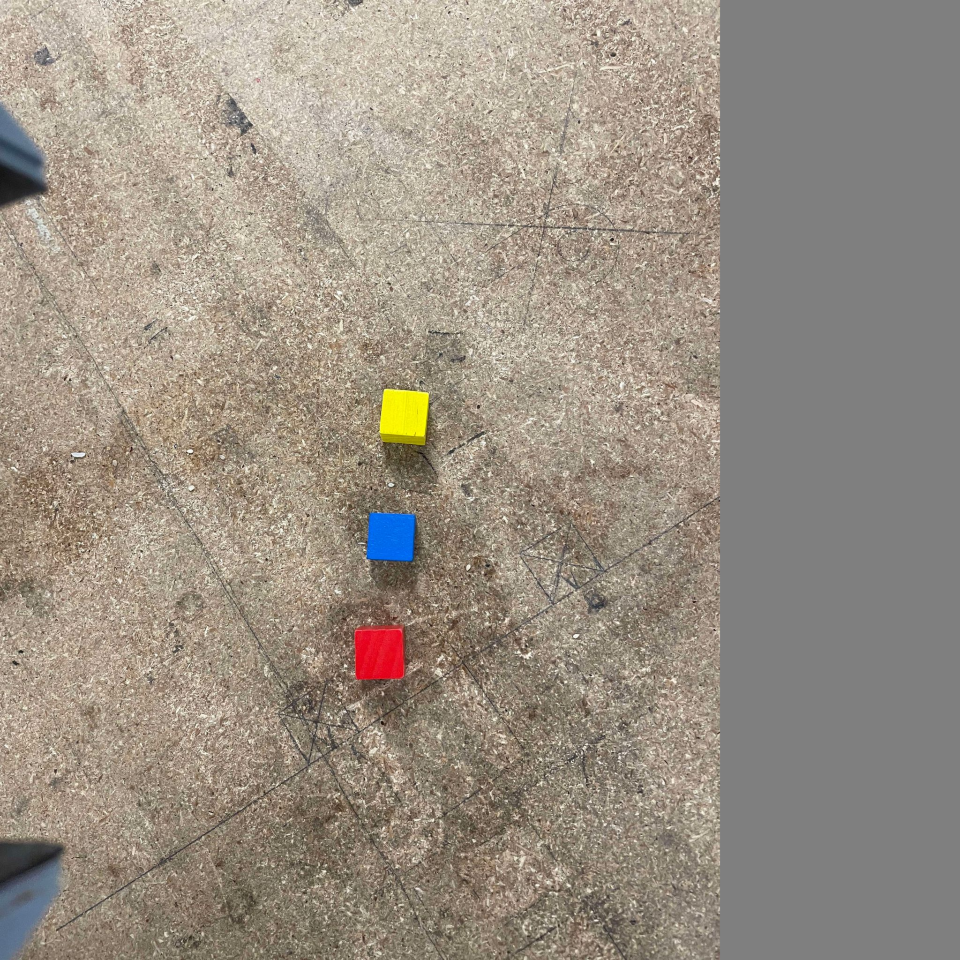

In [24]:
from transformers.utils.constants import OPENAI_CLIP_MEAN, OPENAI_CLIP_STD

def get_preprocessed_image(pixel_values):
    pixel_values = pixel_values.squeeze().numpy()
    unnormalized_image = (pixel_values * np.array(OPENAI_CLIP_STD)[:, None, None]) + np.array(OPENAI_CLIP_MEAN)[:, None, None]
    unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
    unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
    unnormalized_image = Image.fromarray(unnormalized_image)
    return unnormalized_image

unnormalized_image = get_preprocessed_image(inputs.pixel_values)
unnormalized_image

In [25]:
# url = "image.png"
url = "test.jpg"
# image = Image.open(requests.get(url, stream=True).raw)
# convert image to RGB
image = Image.open(url).convert("RGB")
texts = [["a photo of a yellow block"]]
inputs = processor(text=texts, images=image, return_tensors="pt")
outputs = model(**inputs)

# Target image sizes (height, width) to rescale box predictions [batch_size, 2]
# target_sizes = torch.Tensor([image.size[::-1]])
# target_sizes = torch.Tensor([image.size[::-1]])
target_sizes = torch.Tensor([unnormalized_image.size[::-1]])
# Convert outputs (bounding boxes and class logits) to Pascal VOC Format (xmin, ymin, xmax, ymax)
results = processor.post_process_object_detection(outputs=outputs, target_sizes=target_sizes, threshold=0.1)
i = 0  # Retrieve predictions for the first image for the corresponding text queries
text = texts[i]
boxes, scores, labels = results[i]["boxes"], results[i]["scores"], results[i]["labels"]
for box, score, label in zip(boxes, scores, labels):
    box = [round(i, 2) for i in box.tolist()]
    print(f"Detected {text[label]} with confidence {round(score.item(), 3)} at location {box}")
boxes = [b.tolist() + [s] for b, s in zip(boxes, scores.tolist())]


Detected a photo of a yellow block with confidence 0.743 at location [379.16, 388.44, 428.19, 446.11]
Detected a photo of a yellow block with confidence 0.371 at location [366.18, 513.27, 415.64, 564.11]
Detected a photo of a yellow block with confidence 0.319 at location [354.36, 627.08, 404.38, 681.12]


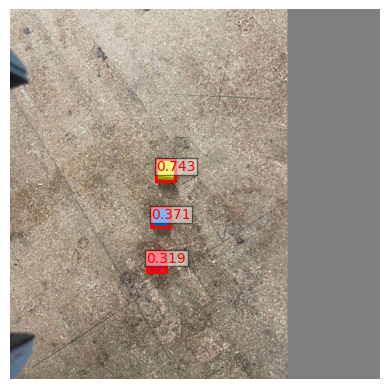

In [26]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import requests
from PIL import Image
from io import BytesIO

# Bounding box coordinates and confidence levels
# boxes = [
#     [341.67, 23.39, 642.32, 371.35, 0.614],
#     [6.75, 51.96, 326.62, 473.13, 0.665]
# ]

visualized_image = unnormalized_image.copy()

# img = image
img = visualized_image

# Plot the image
fig, ax = plt.subplots(1)
ax.imshow(img)

width_ratio = 1
height_ratio = 1
width = orig_img.size[1]
height = orig_img.size[0]
if width > height:
    height_ratio = height / width
elif height > width:
    width_ratio = width / height

# Add bounding boxes
for box in boxes:
    x1, y1, x2, y2, confidence = box
    width = x2 - x1
    height = y2 - y1
    rect = patches.Rectangle((x1, y1), width, height, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    plt.text(x1, y1, f'{confidence:.3f}', color='red', verticalalignment='top', bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 1})

plt.axis('off')
plt.show()

In [7]:
import sys
sys.path.append("../")
from magpie.perception.label_owlvit import LabelOWLViT
path = "google/owlvit-base-patch32"
label_vit = LabelOWLViT(pth=path, topk=3)

C:\Users\willi\AppData\Roaming\Python\Python311\site-packages\transformers\utils\generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


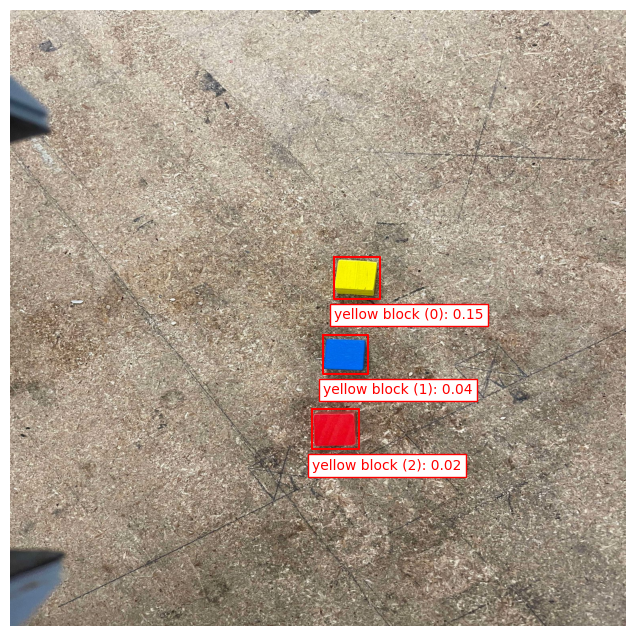

In [9]:
import numpy as np
label_vit.set_threshold(0.001)
image = np.array(image)
queries = ["a photo of a yellow block"]
abbrevq = ["yellow block"]
bboxes, uboxes = label_vit.label(image, queries, abbrevq, plot=True, topk=True)


In [12]:
bboxes

[([0.48476483672857285,
   0.18550999835133553,
   68.32765128463507,
   29.101728167384863],
  'green block'),
 ([33.07115979492664,
   -0.07721375674009323,
   63.9168905466795,
   6.916184172034264],
  'green block'),
 ([38.222758043557405,
   -7.651373744010925e-05,
   67.82954437658191,
   6.7085462380200624],
  'green block'),
 ([43.169306963682175,
   0.253014650195837,
   221.2185661494732,
   24.375277623534203],
  'green block'),
 ([-3.3182483911514282,
   0.2027076818048954,
   340.4162794351578,
   35.26627719774842],
  'green block'),
 ([2.291097342967987,
   -0.14974715188145638,
   385.05788415670395,
   54.19734193012118],
  'green block'),
 ([279.7043688222766,
   -0.03870720090344548,
   306.9375543668866,
   5.519368306268007],
  'green block'),
 ([279.56161327660084,
   0.03336487337946892,
   359.74358074367046,
   7.144707100465894],
  'green block'),
 ([-9.217243492603302,
   0.6880115270614624,
   655.7585600018501,
   40.7495006993413],
  'green block'),
 ([329